## Overview

### ASCII Color Channel text embedding method overview

1. embed text into a 64x64 RGB raw image
2. Give the embedded image to the model
3. Model modifies the remaining pixels to look like a face

The limited number of pixels will inevitably limit the number of characters, but we're looking for a way to embed the character in a way that best suits the model while pushing the limit.

The current method of embedding text into an image is to convert each character to its ASCII number and store it in one of the RGB color channels of the 64 pixels. So we'll be able to store 192 characters per image. It is also worth noting that increasing the number of characters will result in more occupied pixels in the raw input image, thus most likely decreasing the quality of the output avatar.

We'll use the first color channel of the top-left, down-left, and down-right pixels to store metadata to aid in text extraction:

  - top-left(2nd index): text length
  - down-left(170th index): random seed to generate color channel index order
  - down-right(189th index): version number for backward compatibility in case of a new embedding algorithm, etc.
    - We'll assign a random number in range of 0-255 to each version.

The order of filling the color channels is important:

  - The order should be consistent in order for the model to learn to generate avatars better and to make the decoding process easier.
    - The user can provide a random seed to shuffle the order of the indices, which can be stored at a fixed position in the image.
  - We don't want any of the occupied color channels to overlap unless there is no empty one left (after 64 characters)
  - Given the normal distribution of left-right symmetry in training examples, the order of filling color channels should be such that it results in a symmetric input image.

    ![normal distribution of avatars symmetry](./assets/normal-dist-plot.png)
    
  - It's best to use different color channels in symmetric pixels to give the model a chance to change the remaining color channels to make pixels equal.

---

Advantages of ASCII-Color-Channel method:

  1. Straightforward
  2. Filling only one color channel per a character allows the model to modify the available color channels of the same pixel to come up with the best color to create the avatar

Disadvantages:

  1. Limitation in character range: 0-255 (color channel intensity)
  2. Low diversity of data; i.e. the most useful characters are in the range of 20-126 in ASCII table


## Code representation

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
import math
import random

from settings import *

In [ ]:
def show_img(img: ndarray, title: str = ''):
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

ASCII characters in the range of 0-255:

```[special characters] !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ [special characters]```

### Generate an asymmetric order for color channel indexes

In [4]:
def gen_pixel_order_v1(random_seed: int):
    np.random.seed(random_seed)

    left_pixels = (
        np.arange(0, 64)
        .reshape(8, 8)[:, :4]   # pick left pixels
        .reshape(-1)            # convert to 1d array
    )

    # shuffle left pixels
    shuffled_left_pixels = np.random.permutation(left_pixels)

    index_order = []

    # for each color channel (RGB: 0 for Red, 1 for Green, 2 for Blue)
    for left, right in zip([2, 0, 1], [0, 1, 2]):
        for pixel in shuffled_left_pixels:
            if pixel == 0:
                row = 1
            elif pixel % 8 == 0:
                row = pixel // 8 + 1
            else:
                row = math.ceil(pixel / 8)
            
            first = (row - 1) * 8
            last = row * 8 - 1
            position = pixel - first
            mirror = last - position

            # append index for the current channel
            index_order.append(pixel*3 + left)

            # append index for the mirrored channel
            index_order.append(mirror*3 + right)

    # remove the first color channel to store the text length
    index_order.remove(TEXT_LENGTH_INDEX)

    # remove the down-left pixels first color channel to store random seed
    index_order.remove(RANDOM_SEED_INDEX)

    # remove the down-right pixels first color channel to store version
    index_order.remove(VERSION_NUM_INDEX)

    return index_order

### embedding text in the color channels in the specified order

In [5]:
def embed_raw_img_v1(text: str, random_seed: int):
    max_text_len = 188
    text_length = len(text)

    if text_length > max_text_len:
        raise Exception(
            message=f'Text must be shorter than {max_text_len} characters.')

    index_order = gen_pixel_order_v1(random_seed)

    img = np.zeros(8*8*3, np.int16)

    img[TEXT_LENGTH_INDEX] = text_length
    img[RANDOM_SEED_INDEX] = random_seed
    img[VERSION_NUM_INDEX] = V1_NUMBER          # version number

    for i, c in enumerate(text):
        img[index_order[i]] = ord(c)

    return img.reshape((8, 8, 3))

Sample embedded text:

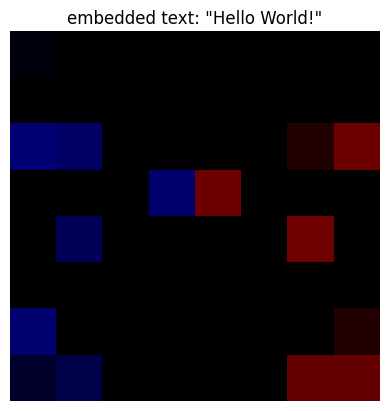

In [6]:
text = 'Hello World!'

img = embed_raw_img_v1(text, DEFAULT_RANDOM_SEED)

show_img(img, f'embedded text: "{text}"')

Se we can generate 192 examples per each avatar to train our model, With original image being a non-embedded image and a raw black image being a fully embedded image representation.

### Text extraction

In [7]:
def extract_text(img: ndarray):
    if img.ndim == 3:
        img = img.reshape(-1)
    
    version_num = img[VERSION_NUM_INDEX]
    if version_num == V1_NUMBER:
        text_length = img[TEXT_LENGTH_INDEX]
        random_seed = img[RANDOM_SEED_INDEX]
        index_order = gen_pixel_order_v1(random_seed)

    text = ''

    for i in range(text_length):
        text += chr(img[index_order[i]])

    return text

Extract embedded text from image:

In [8]:
text = extract_text(img)
print(text)

Hello World!


### Model

Illustrating the expected output, and input of the model

In [9]:
def generate_input(img: ndarray, random_seed: int,
                   text_length: int, version_num: int):
    index_order = gen_pixel_order_v1(random_seed)

    result_img = img.copy().reshape(-1)

    # embed metadata
    result_img[TEXT_LENGTH_INDEX] = text_length
    result_img[RANDOM_SEED_INDEX] = random_seed
    result_img[VERSION_NUM_INDEX] = version_num

    excess_indexes = index_order[text_length:]
    result_img[excess_indexes] = 0

    return result_img

Generate a sample input based on an avatar

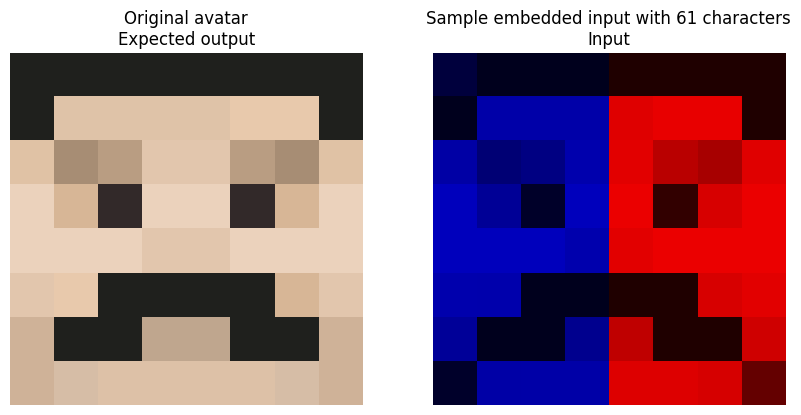

In [10]:
avatar_img = Image.open('../valid_faces/00002.png')
avatar_img = np.array(avatar_img)

text_length = 61

input_img = generate_input(avatar_img, DEFAULT_RANDOM_SEED, text_length, V1_NUMBER)

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(avatar_img)
axs[0].axis('off')
axs[0].set_title('Original avatar\nExpected output')

axs[1].imshow(input_img.reshape((8, 8, 3)))
axs[1].axis('off')
axs[1].set_title(f'Sample embedded input with {text_length} characters\nInput')

plt.show()

## Ideas & Thoughts

- Calculate the estimated location of the most important pixels, such as eyes, mouth, hair, etc., and consider them when defining the order of the color channels.
- Model decides the order of embedded color channels.